In [1]:
from importlib import reload
import config
reload(config)
import os

import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader

# %load_ext tensorboard

import dataset, loss, model, trainer
import numpy as np
import util

%pylab inline

Populating the interactive namespace from numpy and matplotlib


D:\Github\smlm-dl\smlm_dl\dataset.py:364: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


42:	 [id = 42.000,], [A = 1477.916,], [bg = 4.361,], [x = -6.495,], [y = -1.062,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
5:	 [id = 5.000,], [A = 1188.883,], [bg = 62.004,], [x = 3.003,], [y = 8.929,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
39:	 [id = 39.000,], [A = 685.750,], [bg = 81.388,], [x = 6.474,], [y = 8.774,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
235:	 [id = 235.000,], [A = 1842.729,], [bg = 25.280,], [x = -4.608,], [y = -0.202,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
238:	 [id = 238.000,], [A = 1790.853,], [bg = 73.800,], [x = -9.438,], [y = 2.260,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
236:	 [id = 236.000,], [A = 1259.601,], [bg = 9.536,], [x = -6.528,], [y = 1.724,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
23:	 [id = 23.000,], [A = 1335.609,], [bg = 38.026,], [x = -1.416,], [y = 1.465,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
62:	 [id = 62.000,], [A = 1064.955,], [bg = 9.340,], [x = 4.662,], [

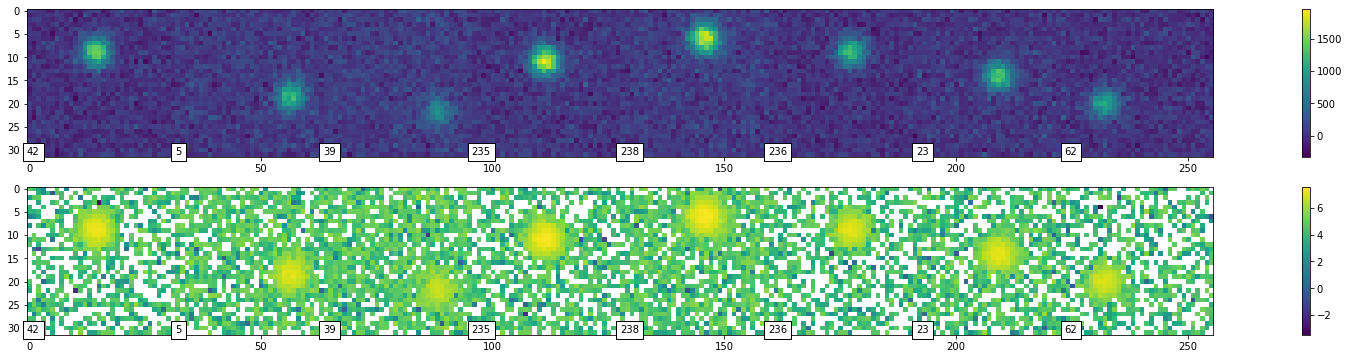

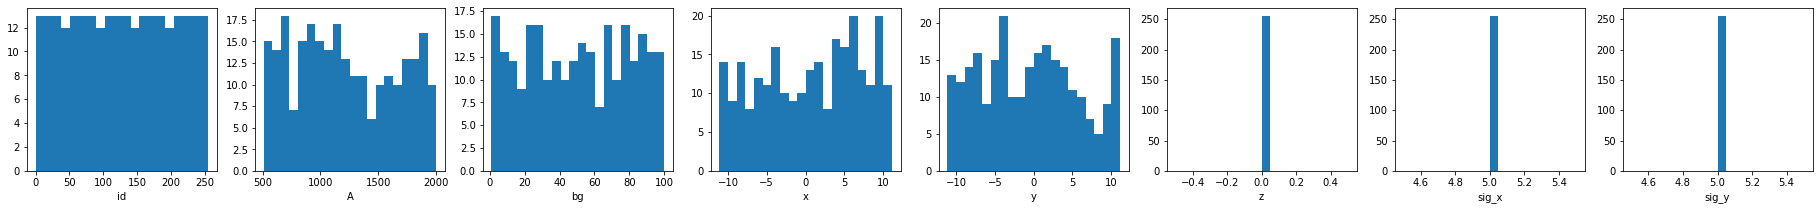

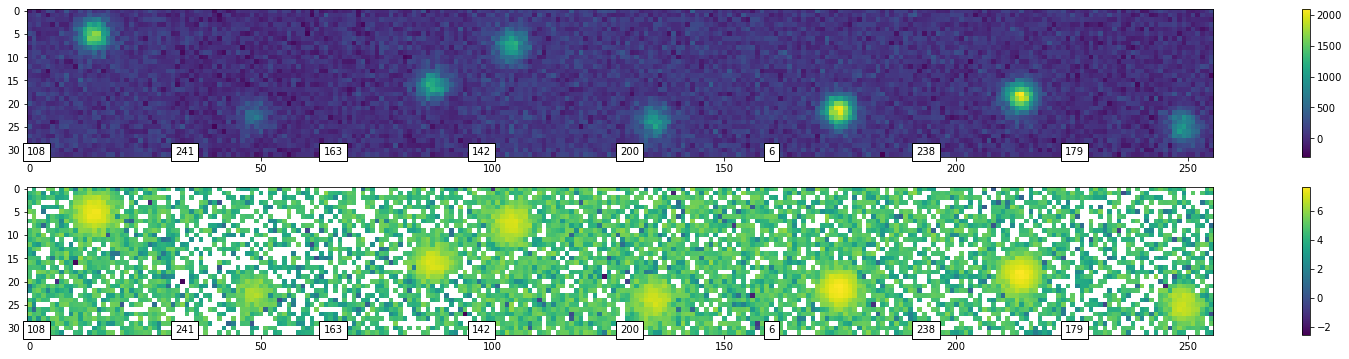

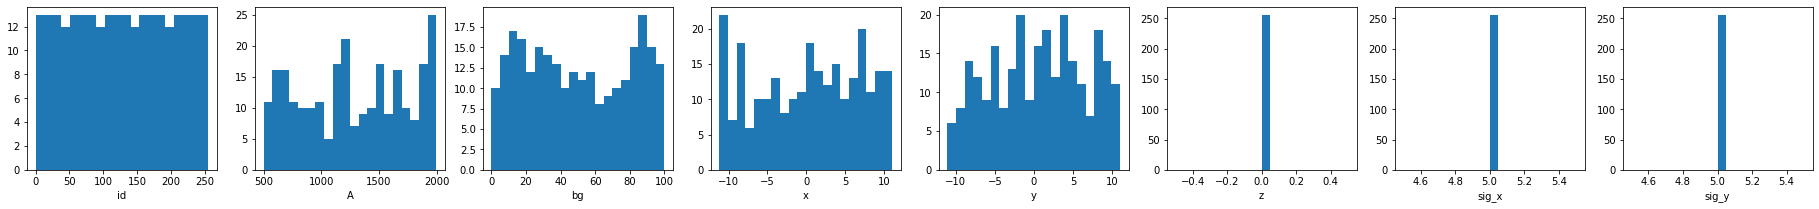

In [2]:
reload(dataset)

settings = {
    # 'out_size': (64,64),
    'length': (256, 1),
    'dropout_p': 0,
    # 'psf_params': {'z':[-10,10]},
    # 'psf_params': {'A':[200, 500], 'bg':[0, 0]},
    # 'psf_zerns': psf_zerns,
    'noise_params': {'poisson': True, 'gaussian': 100},
    # 'normalize': False,
    # 'padding': (4,4),
    # 'random_z': True,
    # "augmentations":{},
    # "augmentations":{"pixel shift":(4,4), }#"add noise":0.1},
    
}

training_data = dataset.Gaussian2DPSFDataset(**settings)
dataset.inspect_images(training_data)
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)

valid_data = dataset.Gaussian2DPSFDataset(**settings)
dataset.inspect_images(valid_data)
valid_dataloader = DataLoader(valid_data, batch_size=256, shuffle=True)

['x', 'y', 'A', 'sig', 'bg']
Layer (type (var_name))                       Output Shape              Param #
Gaussian2DModel                               --                        --
├─ConvImageEncoderModel (encoder)             [128, 5, 1, 1]            --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [128, 16, 16, 16]         --
│    │    │    └─Conv2d (0)                   [128, 16, 32, 32]         160
│    │    │    └─GELU (1)                     [128, 16, 32, 32]         --
│    │    │    └─Conv2d (2)                   [128, 16, 32, 32]         2,320
│    │    │    └─GELU (3)                     [128, 16, 32, 32]         --
│    │    │    └─MaxPool2d (4)                [128, 16, 16, 16]         --
│    │    │    └─Dropout2d (5)                [128, 16, 16, 16]         --
│    │    └─Sequential (conv_layer1)          [128, 32, 8, 8]           --
│    │    │    └─Conv2d (0)                   [128, 32, 16, 16

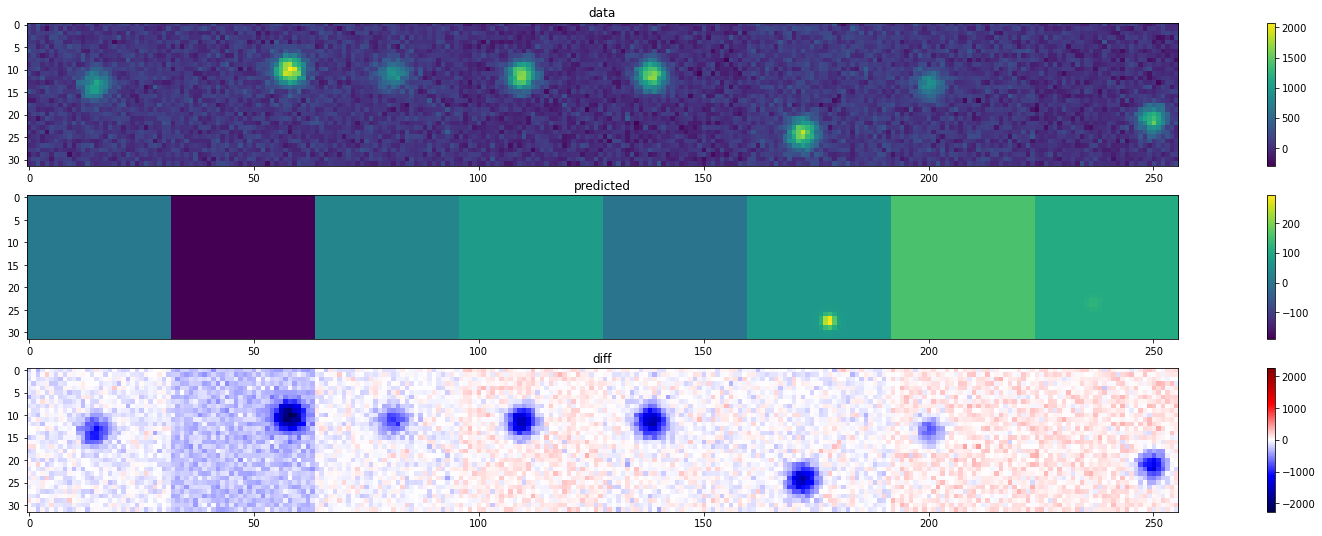

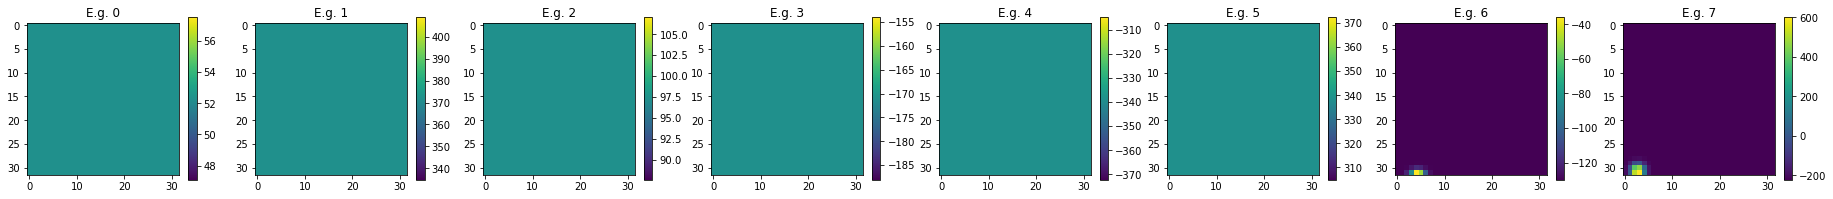

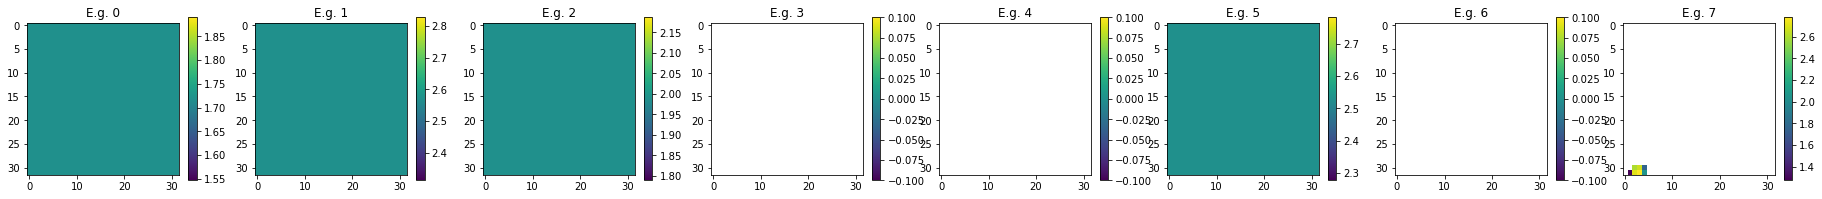

In [10]:
reload(model)

fitting_model = model.Gaussian2DModel(
                                      # img_size=(32,32),
                                      fit_params=['x','y','A','sig','bg'],
                                      max_psf_count=1,
                                      encoder_params={
                                          # "depth":3,
                                                      # "skip_channels":4,
                                                      # "first_layer_out_channels":16,
                                                     }
                                     )

print(fitting_model.fit_params)


print(summary(fitting_model, input_size=(128,1,32,32), row_settings=["var_names"], depth=4))

model.check_model(fitting_model, train_dataloader)

In [11]:
reload(loss)

<module 'loss' from 'D:\\Github\\smlm-dl\\smlm_dl\\loss.py'>

In [ ]:
# loss_func = loss.GaussMLECameraLoss(gain=1, offset=0, var=100*2)
# optim_func = torch.optim.AdamW(fitting_model.parameters(), lr=1e-4)

# training = trainer.FittingTrainer(fitting_model, train_dataloader, optimizer=optim_func, loss_function=loss_func)
# training.train_and_validate(100000, 10, 100)

In [17]:
loss_func = loss.GaussPoissonMLECameraLoss(gain=1, offset=0, var=100**2, debug=True)
optim_func = torch.optim.AdamW(fitting_model.parameters(), lr=2e-5)

# training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, loss_function=loss_func)
training = trainer.FittingTrainer(fitting_model, train_dataloader, None, optimizer=optim_func, loss_function=loss_func)
training.train_and_validate(2, 10, 100)

No validation data supplied. Remember to set prior to training.
CUDA not available. Defaulting to CPU
Device: cpu
Saved to : D:\Pytorch\runs\2022-03-25_14-45-58_DESKTOP-7NNT713\model.ptm


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

poisson nll tensor(0., grad_fn=<SelectBackward0>) tensor(0., grad_fn=<SelectBackward0>)
gaussian nll tensor(5.7715, grad_fn=<SelectBackward0>) 0.9189385332046727
noises tensor(0., grad_fn=<SelectBackward0>) tensor(152.7309, grad_fn=<SubBackward0>) tensor(152.7309)
p tensor(0., grad_fn=<DivBackward0>)
1
poisson nll tensor(0., grad_fn=<SelectBackward0>) tensor(0., grad_fn=<SelectBackward0>)
gaussian nll tensor(5.7715, grad_fn=<SelectBackward0>) 0.9189385332046727
noises tensor(0., grad_fn=<SelectBackward0>) tensor(152.7309, grad_fn=<SubBackward0>) tensor(152.7309, grad_fn=<SelectBackward0>)
p tensor(0., grad_fn=<DivBackward0>)
poisson nll tensor(0., grad_fn=<SelectBackward0>) tensor(0., grad_fn=<SelectBackward0>)
gaussian nll tensor(6.4235, grad_fn=<SelectBackward0>) 0.9189385332046727
noises tensor(0., grad_fn=<SelectBackward0>) tensor(190.7011, grad_fn=<SubBackward0>) tensor(190.7011)
p tensor(0., grad_fn=<DivBackward0>)
poisson nll tensor(0., grad_fn=<SelectBackward0>) tensor(0., grad

dict_keys(['poisson_nll_a', 'poisson_nll_b', 'gaussian_nll_a', 'gaussian_nll_b', 'input', 'target', 'poisson_noise', 'gaussian_noise', 'nll'])


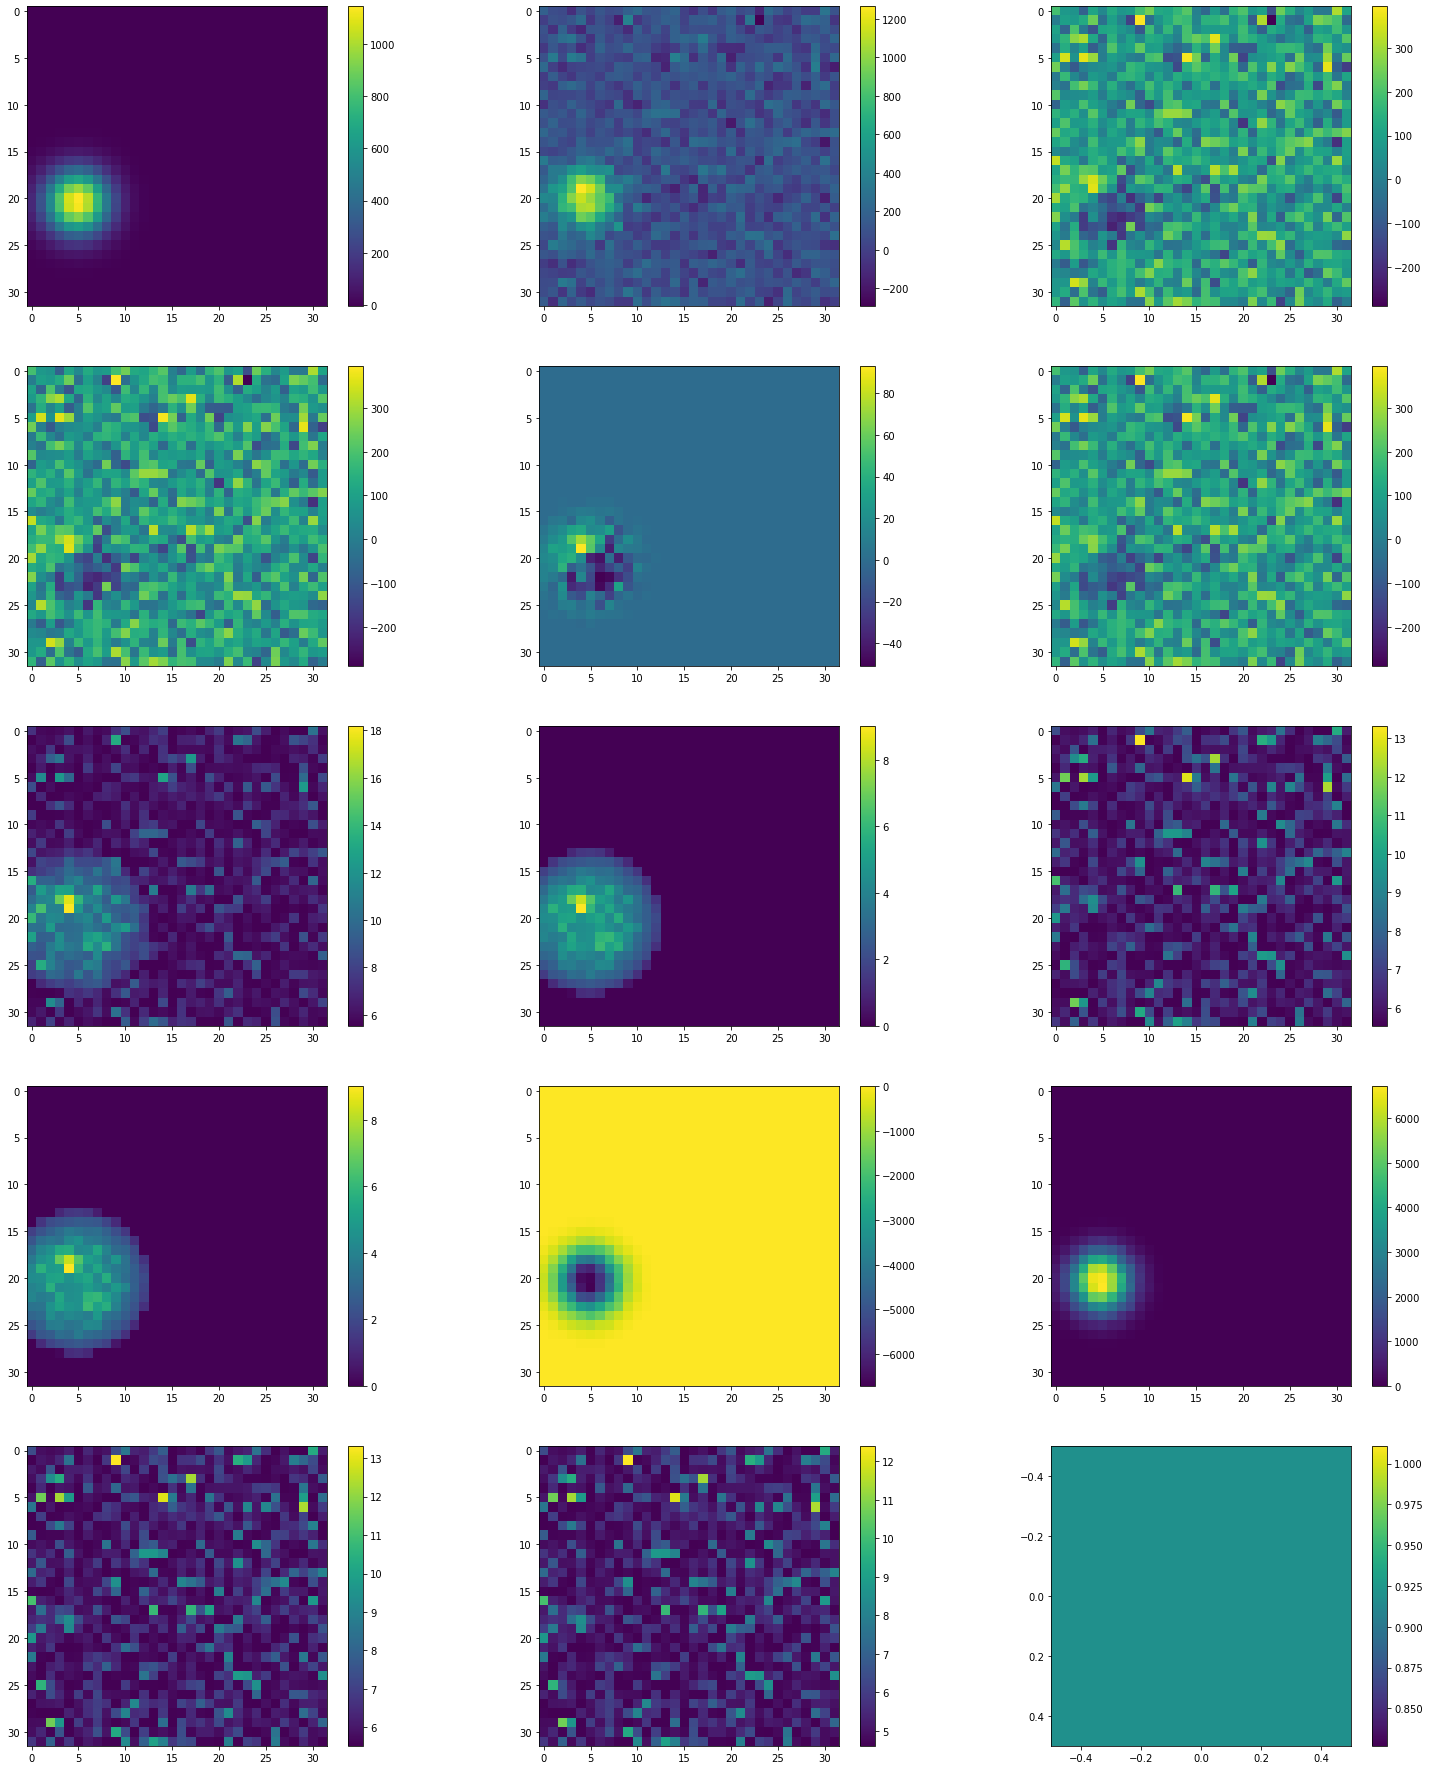

In [18]:
print(training.loss_function.cached_images.keys())
fig, axes = subplots(5, 3, figsize=(26,32))

im = axes[0,0].imshow(training.loss_function.cached_images["input"][0,0])
colorbar(im, ax=axes[0,0])
im = axes[0,1].imshow(training.loss_function.cached_images["target"][0,0])
colorbar(im, ax=axes[0,1])
im = axes[0,2].imshow(training.loss_function.cached_images["target"][0,0] - training.loss_function.cached_images["input"][0,0])
colorbar(im, ax=axes[0,2])

im = axes[1,0].imshow(training.loss_function.cached_images["poisson_noise"][0,0] + training.loss_function.cached_images["gaussian_noise"][0,0])
colorbar(im, ax=axes[1,0])
im = axes[1,1].imshow(training.loss_function.cached_images["poisson_noise"][0,0])
colorbar(im, ax=axes[1,1])
im = axes[1,2].imshow(training.loss_function.cached_images["gaussian_noise"][0,0])
colorbar(im, ax=axes[1,2])

im = axes[2,0].imshow(training.loss_function.cached_images["nll"][0,0])
colorbar(im, ax=axes[2,0])
im = axes[2,1].imshow(training.loss_function.cached_images["poisson_nll_a"][0,0]+training.loss_function.cached_images["poisson_nll_b"][0,0])
colorbar(im, ax=axes[2,1])
im = axes[2,2].imshow(training.loss_function.cached_images["gaussian_nll_a"][0,0]+training.loss_function.cached_images["gaussian_nll_b"])
colorbar(im, ax=axes[2,2])

im = axes[3,0].imshow(training.loss_function.cached_images["poisson_nll_a"][0,0]+training.loss_function.cached_images["poisson_nll_b"][0,0])
colorbar(im, ax=axes[3,0])
im = axes[3,1].imshow(training.loss_function.cached_images["poisson_nll_a"][0,0])
colorbar(im, ax=axes[3,1])
im = axes[3,2].imshow(training.loss_function.cached_images["poisson_nll_b"][0,0])
colorbar(im, ax=axes[3,2])

im = axes[4,0].imshow(training.loss_function.cached_images["gaussian_nll_a"][0,0]+training.loss_function.cached_images["gaussian_nll_b"])
colorbar(im, ax=axes[4,0])
im = axes[4,1].imshow(training.loss_function.cached_images["gaussian_nll_a"][0,0])
colorbar(im, ax=axes[4,1])
im = axes[4,2].imshow(training.loss_function.cached_images["gaussian_nll_b"][None,None])
colorbar(im, ax=axes[4,2])